In [2]:
# Analyzing the Main Dataset

import chess.pgn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as skl
import statsmodels.api as sm

## Building the Master Dataframe

#To split up the data, we will read and parse each `.pgn` file individually, load the data into a dataframe, and then check to see if the headers and data were processed correctly

from collections import defaultdict

def read_pgn_file(path, params):
    list_of_rows = []
    with open(path, 'r', encoding = 'utf-8', errors = 'ignore') as pgn_file:
        #print(path, '\n')
        for game in pgn_file:
            curr_game = chess.pgn.read_headers(pgn_file)
            curr_row = defaultdict(str)
            #print(headers)
            for info in params:
                #print(info)
                try: 
                    #print(path)
                    #print(headers[info])
                    #print(headers[info])
                    curr_row[info] = curr_game[info]
                    #print(curr_row)
                except:
                    curr_row[info] = None
                
            list_of_rows.append(curr_row)
            
        games_df = pd.DataFrame(list_of_rows, columns = params)
        pgn_file.close()
    
    return games_df

# okay to use for now, improve on this later

Reading the `.pgn` files

The relevant data fields:
* Event: will be needed to categorize if the tournament is Standard, Blitz, Rapid, or Speed
* Result
* WhiteElo
* BlackElo
* ECO
* Opening
* Variation (tenuous, due to the sheer number of variations and their dependence on the Opening, this data field might be useless)
* WhiteFideId
* BlackFideId (will use these instead of names to identify players)

* Moves (the first 6 moves)

In [3]:
# Read data
import os

params = ['Event', 'Result', 'WhiteElo', 'BlackElo', 'ECO', 'Opening', 'Variation',
          'WhiteFideId', 'BlackFideId']

list_of_df = []

directory = '/Users/weiyutong/Documents/twic_chess_pgn_files/'

file_list = os.listdir(directory)

for file in file_list:
    if file.startswith('twic'):
        file_df = read_pgn_file(directory + file, params)
        list_of_df.append(file_df)

game_data = pd.concat(list_of_df)

#game_data 

## Cleaning up the Master Dataframe

#game_data.describe()

game_data.drop(columns = 'Event', inplace = True)

game_data.dropna(subset = ['Result', 'WhiteElo', 'BlackElo'], inplace = True) # drop all games without Elos or Results 

#game_data.describe()

game_data.groupby('Result').size()

game_data = game_data[game_data.Result.isin(['1-0', '0-1', '1/2-1/2'])]

game_data = game_data.astype({'WhiteElo':'int64', 'BlackElo':'int64'})
#game_data.dtypes

In [4]:
## Pickle the Master Dataframe for Ease of Loading

import pickle

game_data.to_pickle('./Data/game_data.pickle')

In [1]:
import pandas as pd
game_data = pd.read_pickle('./Data/game_data.pickle')

In [2]:
game_data

,Result,WhiteElo,BlackElo,ECO,Opening,Variation,WhiteFideId,BlackFideId
0,1/2-1/2,2741,2747,A48,King's Indian,London system,2000024,4102142
1,1-0,2712,2616,D70,Neo-Gruenfeld defence,None,4152956,4140419
2,1/2-1/2,2593,2723,D97,Gruenfeld,"Russian, Prins variation",14401487,3503240
3,1/2-1/2,2695,2567,C03,French,Tarrasch,310204,4102878
4,0-1,2538,2697,A04,Reti opening,None,4156021,14107201
...,...,...,...,...,...,...,...,...
6005,1/2-1/2,1697,1870,C01,French,exchange variation,775002,761338
6006,0-1,1804,2088,E85,None,None,769762,758280
6007,1/2-1/2,1972,1747,C47,Four knights,"Scotch, 4...exd4",774227,786047
6008,0-1,1756,1910,A05,Reti opening,None,788414,785016


In [3]:
## Distilling Data Based on Columns Counts

def make_count_df(df, col_list):
    """
    Outputs a dataframe which has multiindices (col_1, col_2) and one column the count per multiindex
    """
    new_df = df.groupby(by = col_list).agg('count')['WhiteElo'].astype(int).to_frame()
    new_df.rename(columns = {'WhiteElo':'Count'}, inplace = True)
    
    return new_df

def make_ratio_df(df, index):
    """
    Adds columns Count_sum which calculates the sum of Count column per each group index
    and Ratio which is Count over Count_sum per row
    """
    sum_df = df.groupby(by = index).sum().astype(int)
    new_df = df.join(sum_df, how = 'left', rsuffix = '_sum')
    new_df['Ratio'] = new_df['Count'].divide(new_df['Count_sum'])
    
    return new_df

In [4]:
ECO_count_df = make_count_df(game_data, ['ECO', 'Result'])

ECO_ratio_df = make_ratio_df(ECO_count_df, 'ECO')

ECO_ratio_df['Ratio']

# read_headers() and read_game() can't read Event header field
# deal with this later when we need Event data

### Add Elo Difference

#EloDiff = WhiteElo - BlackElo`

game_data['EloDiff'] = game_data['WhiteElo'] - game_data['BlackElo']

Opening_count_df = make_count_df(game_data, 'Opening')
Opening_count_df

,Count
Opening,
Alapin's opening,16
Alekhine's defence,8120
Amar (Paris) opening,24
Anderssen's opening,412
Anti-Borg (Desprez) opening,54
...,...
Ware (Meadow Hay) opening,15
Woozle defence,25
de Bruycker defence,39


                    Count  Count_sum     Ratio
EloDiffBin Result                             
-201950    1/2-1/2      1          1  1.000000
-1500      0-1          2          2  1.000000
-1400      0-1          4          4  1.000000
-1350      0-1          6          7  0.857143
           1/2-1/2      1          7  0.142857
-1300      0-1         16         18  0.888889
           1-0          1         18  0.055556
           1/2-1/2      1         18  0.055556
-1250      0-1         28         30  0.933333
           1/2-1/2      2         30  0.066667
-1200      0-1         41         48  0.854167
           1-0          1         48  0.020833
           1/2-1/2      6         48  0.125000
-1150      0-1         54         58  0.931034
           1/2-1/2      4         58  0.068966
-1100      0-1         81         85  0.952941
           1-0          3         85  0.035294
           1/2-1/2      1         85  0.011765
-1050      0-1        123        127  0.968504
           1-

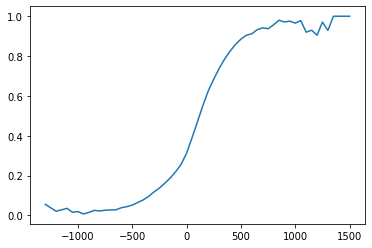

In [53]:
# Linear Regression

#With a significant amount of games at our hands and distilled into a useable form, perform and initial linear fit on it.

## Predict Win Probability Based on Elo & Elo Difference

#Analyze only the games with Sicilian Opening (1. e4 c5) and then expand to more openings

sicilian_df = game_data[game_data['Opening'] == 'Sicilian']

#sicilian_df # 180k games, big enough for our purposes

game_data['WhiteEloBin'] = 50*round(game_data['WhiteElo']/50).astype('int')

game_data['BlackEloBin'] = 50*round(game_data['BlackElo']/50).astype('int')

game_data['EloDiffBin'] = 50*round(game_data['EloDiff']/50).astype('int')


game_data_elo_diff_win_ratio = make_ratio_df(make_count_df(game_data, ['EloDiffBin', 'Result']), 'EloDiffBin')

with pd.option_context("display.max_rows", 1000):
    print(game_data_elo_diff_win_ratio)

game_data_elo_diff_win_ratio.drop((-201950,'1/2-1/2'), inplace = True)

#game_data_elo_diff_win_ratio

all_games_white_win = game_data_elo_diff_win_ratio.loc[game_data_elo_diff_win_ratio.index.get_level_values('Result') == '1-0']


all_games_win_ratio = all_games_white_win.index.get_level_values('EloDiffBin')

x = all_games_win_ratio
y = all_games_white_win['Ratio'].tolist()
### PLOT INTO BAR CHART
plt.plot(x,y)

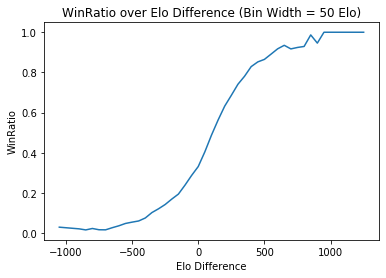

In [60]:
sicilian_count_df = make_count_df(game_data[game_data['Opening'] == 'Sicilian'], ['EloDiffBin', 'Result'])

sicilian_count_ratio_df = make_ratio_df(sicilian_count_df, 'EloDiffBin')

sicilian_white_win = sicilian_count_ratio_df.loc[sicilian_count_ratio_df.index.get_level_values('Result') == '1-0']

x = sicilian_white_win.index.get_level_values('EloDiffBin')

y = sicilian_white_win['Ratio'].tolist()
### PLOT INTO BAR CHART
plt.plot(x,y)
plt.title('WinRatio over Elo Difference (Bin Width = 50 Elo)')
plt.xlabel('Elo Difference')
plt.ylabel('WinRatio')
plt.show()

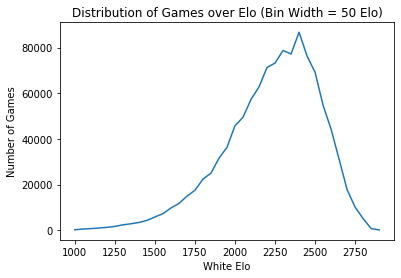

In [73]:
#The shape of these probability curves based on Elo Difference suggest a logistic regression

#What is the distribution of white players' Elo?

Elo_dist = make_count_df(game_data, ['WhiteEloBin'])

plt.plot(Elo_dist)
plt.title('Distribution of Games over Elo (Bin Width = 50 Elo)')
plt.xlabel('White Elo')
plt.ylabel('Number of Games')
plt.show()

In [12]:
white_by_black_elo = make_count_df(game_data, ['WhiteEloBin', 'BlackEloBin', 'Result'])

white_by_black_elo_ratio = make_ratio_df(white_by_black_elo, ['WhiteEloBin', 'BlackEloBin'])

wb_elo_rat_df = white_by_black_elo_ratio.reset_index()

only_white_rat_df = wb_elo_rat_df[wb_elo_rat_df['Result'] == '1-0']

elo_white_win = white_by_black_elo_ratio.loc[white_by_black_elo_ratio.index.get_level_values('Result') == '1-0']
with pd.option_context("display.max_rows", 2000):
    print(elo_white_win)

                                Count  Count_sum     Ratio
WhiteEloBin BlackEloBin Result                            
1000        1000        1-0         2          2  1.000000
            1050        1-0         1          5  0.200000
            1150        1-0         3         10  0.300000
            1200        1-0         5         14  0.357143
            1250        1-0         2         12  0.166667
            1300        1-0         1         10  0.100000
            1350        1-0         4         14  0.285714
            1400        1-0         2          8  0.250000
            1450        1-0         3         14  0.214286
1050        1050        1-0         9         17  0.529412
            1100        1-0         2         11  0.181818
            1150        1-0         5         16  0.312500
            1200        1-0         4         17  0.235294
            1250        1-0         7         24  0.291667
            1300        1-0         7         32  0.2187

In [13]:
Opening_count_df.sort_values('Count', ascending = False).head(20)

,Count
Opening,
Sicilian,180155
French,66233
King's Indian,61741
English,51479
Ruy Lopez,47956
QGD,44920
Caro-Kann,41874
Queen's pawn game,40891
English opening,33861


In [14]:
#Rebuilds game_data_top6

Opening_list = ['Sicilian', 'French', "King's Indian", 'English', 'Ruy Lopez', 'QGD','Caro-Kann']

game_data_top6 = game_data[game_data['Opening'].isin(Opening_list)].reset_index()

dummy_df = pd.get_dummies(game_data_top6['Opening'])

game_data_top6 = game_data_top6.join(dummy_df, how = 'left')

game_data_top6 = game_data_top6.drop(['index', 'Result', 'ECO', 'Opening', 'Variation', 'WhiteFideId', 'BlackFideId'], axis = 1)

white_by_black_elo_ratio = white_by_black_elo_ratio.reset_index()

white_by_black_elo_ratio.set_index(['WhiteEloBin', 'BlackEloBin'], drop = True, inplace = True)

white_by_black_elo_ratio = white_by_black_elo_ratio[white_by_black_elo_ratio['Result'] == '1-0']

game_data_top6.set_index(['WhiteEloBin', 'BlackEloBin'], drop = True, inplace = True)

game_data_top6 = game_data_top6.join(white_by_black_elo_ratio, how = 'left')

game_data_top6.reset_index(drop = True, inplace = True)

game_data_top6.drop(['Result', 'Count', 'Count_sum'], axis = 1, inplace = True)

game_data_top6

,WhiteElo,BlackElo,EloDiff,EloDiffBin,Caro-Kann,English,French,King's Indian,QGD,Ruy Lopez,Sicilian,Ratio
0,1007,1165,-158,-150,0,0,0,0,0,0,1,0.300000
1,1018,1155,-137,-150,0,0,1,0,0,0,0,0.300000
2,1007,1130,-123,-100,0,0,1,0,0,0,0,0.300000
3,1022,1199,-177,-200,0,0,1,0,0,0,0,0.357143
4,1010,1218,-208,-200,0,0,0,0,0,1,0,0.357143
...,...,...,...,...,...,...,...,...,...,...,...,...
494353,2882,2805,77,100,0,1,0,0,0,0,0,0.459459
494354,2876,2781,95,100,0,0,0,0,0,0,1,0.459459
494355,2876,2802,74,50,0,0,0,0,1,0,0,0.459459
494356,2876,2780,96,100,0,0,0,0,0,1,0,0.459459


In [15]:
np.shape(np.where(np.isnan(game_data_top6))) # There's a lot of NaN values! Need to delete those rows

# bad_indices = np.where(np.isnan(game_data_top6['Ratio']))
# game_data_top6 = game_data_top6[~game_data_top6.isin(bad_indices)]

game_data_top6.dropna(axis = 'rows', inplace = True)
game_data_top6

,WhiteElo,BlackElo,EloDiff,EloDiffBin,Caro-Kann,English,French,King's Indian,QGD,Ruy Lopez,Sicilian,Ratio
0,1007,1165,-158,-150,0,0,0,0,0,0,1,0.300000
1,1018,1155,-137,-150,0,0,1,0,0,0,0,0.300000
2,1007,1130,-123,-100,0,0,1,0,0,0,0,0.300000
3,1022,1199,-177,-200,0,0,1,0,0,0,0,0.357143
4,1010,1218,-208,-200,0,0,0,0,0,1,0,0.357143
...,...,...,...,...,...,...,...,...,...,...,...,...
494353,2882,2805,77,100,0,1,0,0,0,0,0,0.459459
494354,2876,2781,95,100,0,0,0,0,0,0,1,0.459459
494355,2876,2802,74,50,0,0,0,0,1,0,0,0.459459
494356,2876,2780,96,100,0,0,0,0,0,1,0,0.459459


In [16]:
# game_data_top6_no_nans = game_data_top6.filter([np.isnan(i) for i in game_data_top6['Ratio']])

# np.where(np.isnan(game_data_top6_no_nans))

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

drop_cols = ['Ratio', 'EloDiffBin', 'WhiteElo', 'BlackElo', 'Caro-Kann']

scaler = StandardScaler()

X, y = game_data_top6.drop(drop_cols, axis = 1), game_data_top6['Ratio']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

least_squared_means = sm.OLS(y_train, sm.add_constant(X_train), missing = 'drop')
fit = least_squared_means.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Ratio   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                 5.366e+05
Date:                Fri, 11 Oct 2019   Prob (F-statistic):               0.00
Time:                        02:55:00   Log-Likelihood:             4.6605e+05
No. Observations:              394743   AIC:                        -9.321e+05
Df Residuals:                  394735   BIC:                        -9.320e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3869      0.000   3271.705      0.000       0.387       0.387
x1             0.2294      0.000   1931.545      0.000       0.229       0.230
x2            -0.0001      0.000     -0.620      0.535      -0.000       0.000
x3             0.0013      0.000      7.361      0.000       0.001       0.002
x4             0.0014      0.000      8.208      0.000       0.001       0.002
x5            -0.0008      0.000     -4.900      0.000      -0.001      -0.000
x6            -0.0031      0.000    -18.685      0.000      -0.003      -0.003
x7             0.0026      0.000     11.903      0.000       0.002       0.003
==============================================================================
Omnibus:                    56365.697   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           280964.943
Skew:                           0.606   Prob(JB):                         0.00
Kurtosis:                       6.951   Cond. No.                         3.64
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It seems like the English Opening feature has a high P-value, use Lasso CV to reduce features

In [38]:
X.drop('English', axis = 1, inplace = True)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

least_squared_means = sm.OLS(y_train, sm.add_constant(X_train), missing = 'drop')
fit = least_squared_means.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Ratio   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                 6.261e+05
Date:                Fri, 11 Oct 2019   Prob (F-statistic):               0.00
Time:                        03:50:39   Log-Likelihood:             4.6605e+05
No. Observations:              394743   AIC:                        -9.321e+05
Df Residuals:                  394736   BIC:                        -9.320e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3869      0.000   3271.707      0.000       0.387       0.387
x1             0.2294      0.000   1932.226      0.000       0.229       0.230
x2             0.0014      0.000      9.492      0.000       0.001       0.002
x3             0.0015      0.000     10.455      0.000       0.001       0.002
x4            -0.0007      0.000     -5.408      0.000      -0.001      -0.000
x5            -0.0030      0.000    -21.857      0.000      -0.003      -0.003
x6             0.0027      0.000     16.558      0.000       0.002       0.003
==============================================================================
Omnibus:                    56362.993   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           280945.164
Skew:                           0.606   Prob(JB):                         0.00
Kurtosis:                       6.951   Cond. No.                         2.40
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
X['EloDiff'].describe()

count    493429.000000
mean          6.492448
std         242.062548
min       -1264.000000
25%        -160.000000
50%           7.000000
75%         171.000000
max        1490.000000
Name: EloDiff, dtype: float64

(array([1.0000e+00, 0.0000e+00, 4.0000e+00, 3.0000e+00, 0.0000e+00,
        3.0000e+00, 8.0000e+00, 6.0000e+00, 2.0000e+00, 8.0000e+00,
        6.0000e+00, 1.3000e+01, 2.1000e+01, 4.7000e+01, 6.7000e+01,
        9.5000e+01, 1.2300e+02, 1.6800e+02, 2.0200e+02, 3.0800e+02,
        4.2700e+02, 5.5700e+02, 6.7000e+02, 8.5500e+02, 1.0440e+03,
        1.3700e+03, 1.7180e+03, 2.1530e+03, 2.6340e+03, 3.2670e+03,
        3.7990e+03, 4.7400e+03, 5.5580e+03, 7.0090e+03, 8.2870e+03,
        1.0700e+04, 1.2685e+04, 1.5800e+04, 1.7921e+04, 1.9617e+04,
        2.1830e+04, 2.1443e+04, 2.0990e+04, 1.9924e+04, 1.9342e+04,
        1.8390e+04, 1.9073e+04, 1.8642e+04, 2.0390e+04, 2.1013e+04,
        2.2709e+04, 2.2554e+04, 1.9889e+04, 1.8712e+04, 1.5565e+04,
        1.3398e+04, 1.0394e+04, 8.9170e+03, 6.8770e+03, 5.7940e+03,
        4.6960e+03, 4.1660e+03, 3.1950e+03, 2.6150e+03, 2.1680e+03,
        1.7020e+03, 1.4130e+03, 1.0130e+03, 9.2400e+02, 7.7500e+02,
        6.0000e+02, 5.1600e+02, 4.0000e+02, 2.80

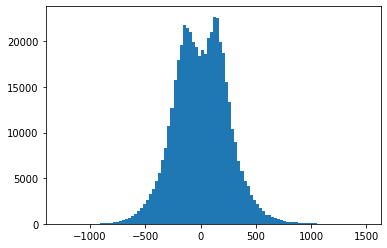

In [70]:
plt.hist(X['EloDiff'], bins = 100)
plt.xlabel('Elo Differe')

In [42]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

vif

,VIF Factor,features
0,1.007854,EloDiff
1,1.000370,French
2,1.000733,King's Indian
3,1.004244,QGD
4,1.000437,Ruy Lopez
5,1.002070,Sicilian


In [43]:
20
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score

print('Coefficients: \n', model.coef_/scaler.scale_)
print('Intercept:', model.intercept_)
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

Coefficients: 
 [ 0.00094784  0.00401027  0.00450976 -0.00258207 -0.01019872  0.00555935]
Intercept: 0.3869305281715199
Mean squared error: 0.01
Variance score: 0.90


In [ ]:
table = 

In [44]:
model.score(X_test, y_test)

0.9047487441811707

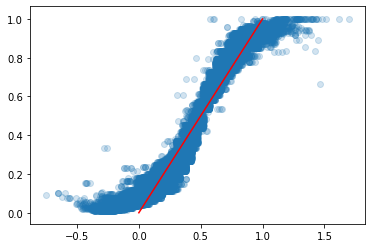

In [79]:
plt.scatter(y_pred, y_test, alpha = 0.2)
plt.plot(np.linspace(0,1,2), np.linspace(0,1,2), color = 'r')
# plt.plot(X_test, y_pred, color='blue', linewidth=3)

In [80]:
X

,EloDiff,French,King's Indian,QGD,Ruy Lopez,Sicilian
0,-158,0,0,0,0,1
1,-137,1,0,0,0,0
2,-123,1,0,0,0,0
3,-177,1,0,0,0,0
4,-208,0,0,0,1,0
...,...,...,...,...,...,...
494353,77,0,0,0,0,0
494354,95,0,0,0,0,1
494355,74,0,0,1,0,0
494356,96,0,0,0,1,0


 Positive coefficients mean that the win probability increases if White uses that opening. Therefore, the best opening out of the top 6 is the Sicilian, and the worst is the Ruy Lopez. Surprisingly, the coefficients for the French, King's Indian, and Sicilian Openings are larger than that of Elo Difference by a few factors, so the choice of utilizing these openings 

Issue in this analysis is that many of the choices for these openings are made by Black. Let's look at 1st moves for White the win ratios for them over a swath of Elo Ratings. Also let's look at the draws for the players

Find those openings which are more effective for white at large negative Elo differences.

In [ ]:
# Use GridSearchCV to improve fit parameters



In [ ]:
### Decision Tree



# Code in Progress

file_path = '/Users/weiyutong/Documents/Github/project_kasparov/Data/test_pgn.pgn'

with open(file_path, 'r') as pgn_file:
    print(file_path, '\n')
#         first_headers = chess.pgn.read_headers(pgn_file)
#         second_headers = chess.pgn.read_headers(pgn_file)

    params = ['[Event', '[Result', '[WhiteElo', '[BlackElo', '[ECO', '[Opening', '[Variation',
          '[WhiteFideId', '[BlackFideId', '1. ']
    
    param_dict = defaultdict(str)
    
    for idx, line in enumerate(pgn_file):
        for param in params:
            if line.startswith(param):
                param_dict[param] = line